# Pulse Sequence Creation: Bell State Preparation

## Introduction

In this notebook, our goal will be to create a pulse sequence that prepares the Bell state

$$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} $$

The standard quantum circuit that creates this state is

<center>
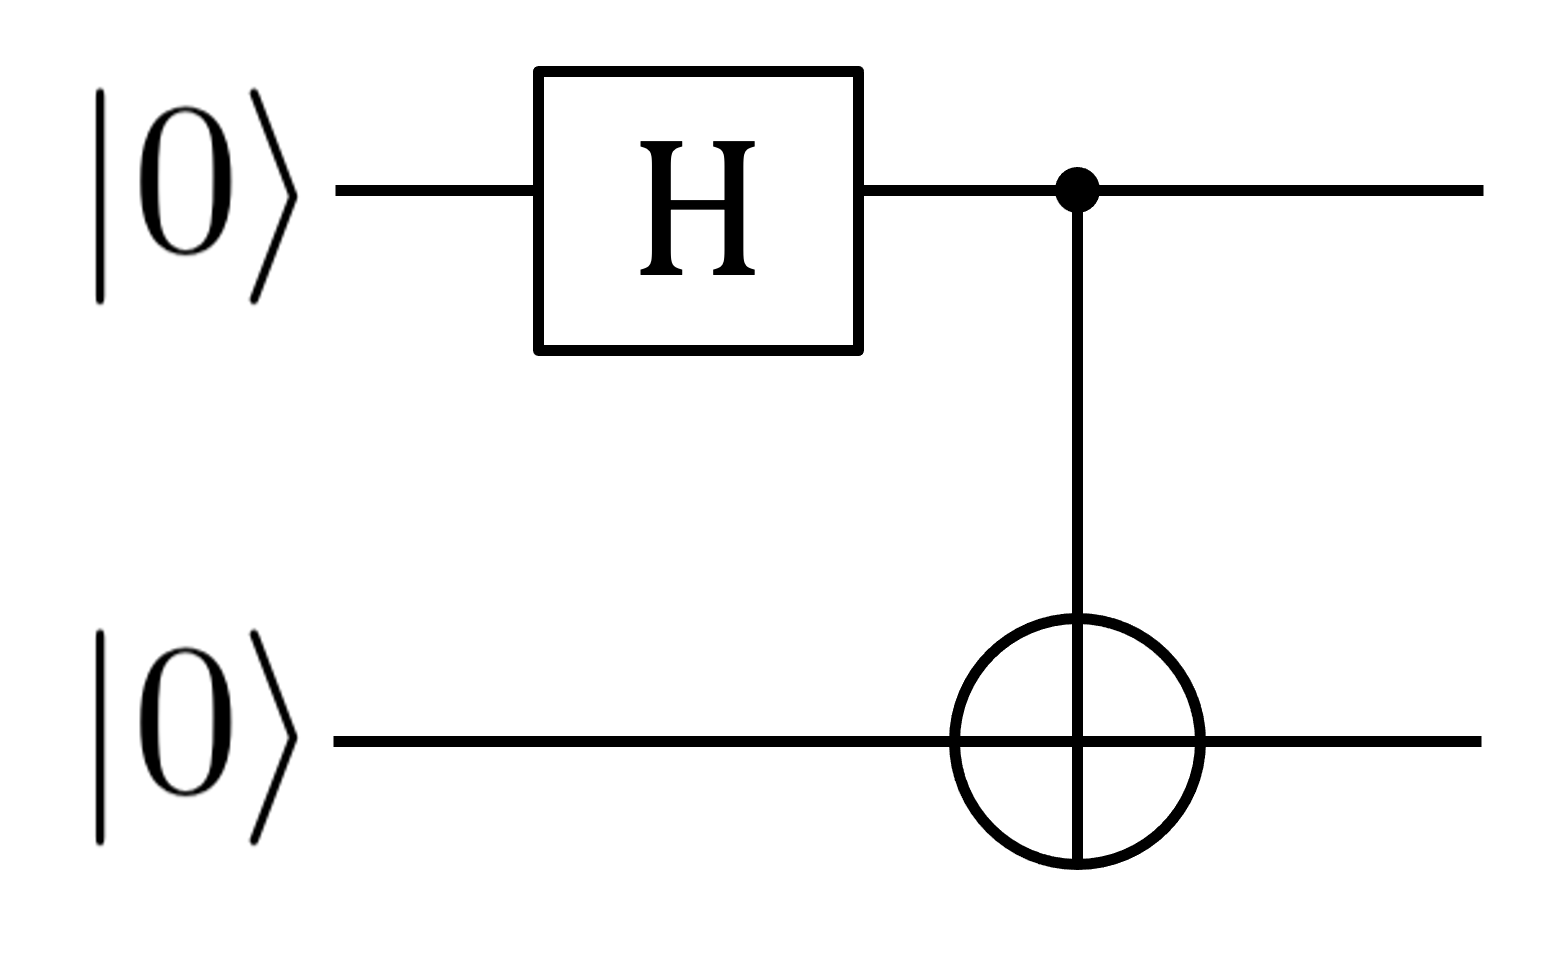
</center>

In order to make it executable on our neutral-atom QPU, we will transpile it into an equivalent version.

### Step 1. Decomposing the CNOT gate

<center>
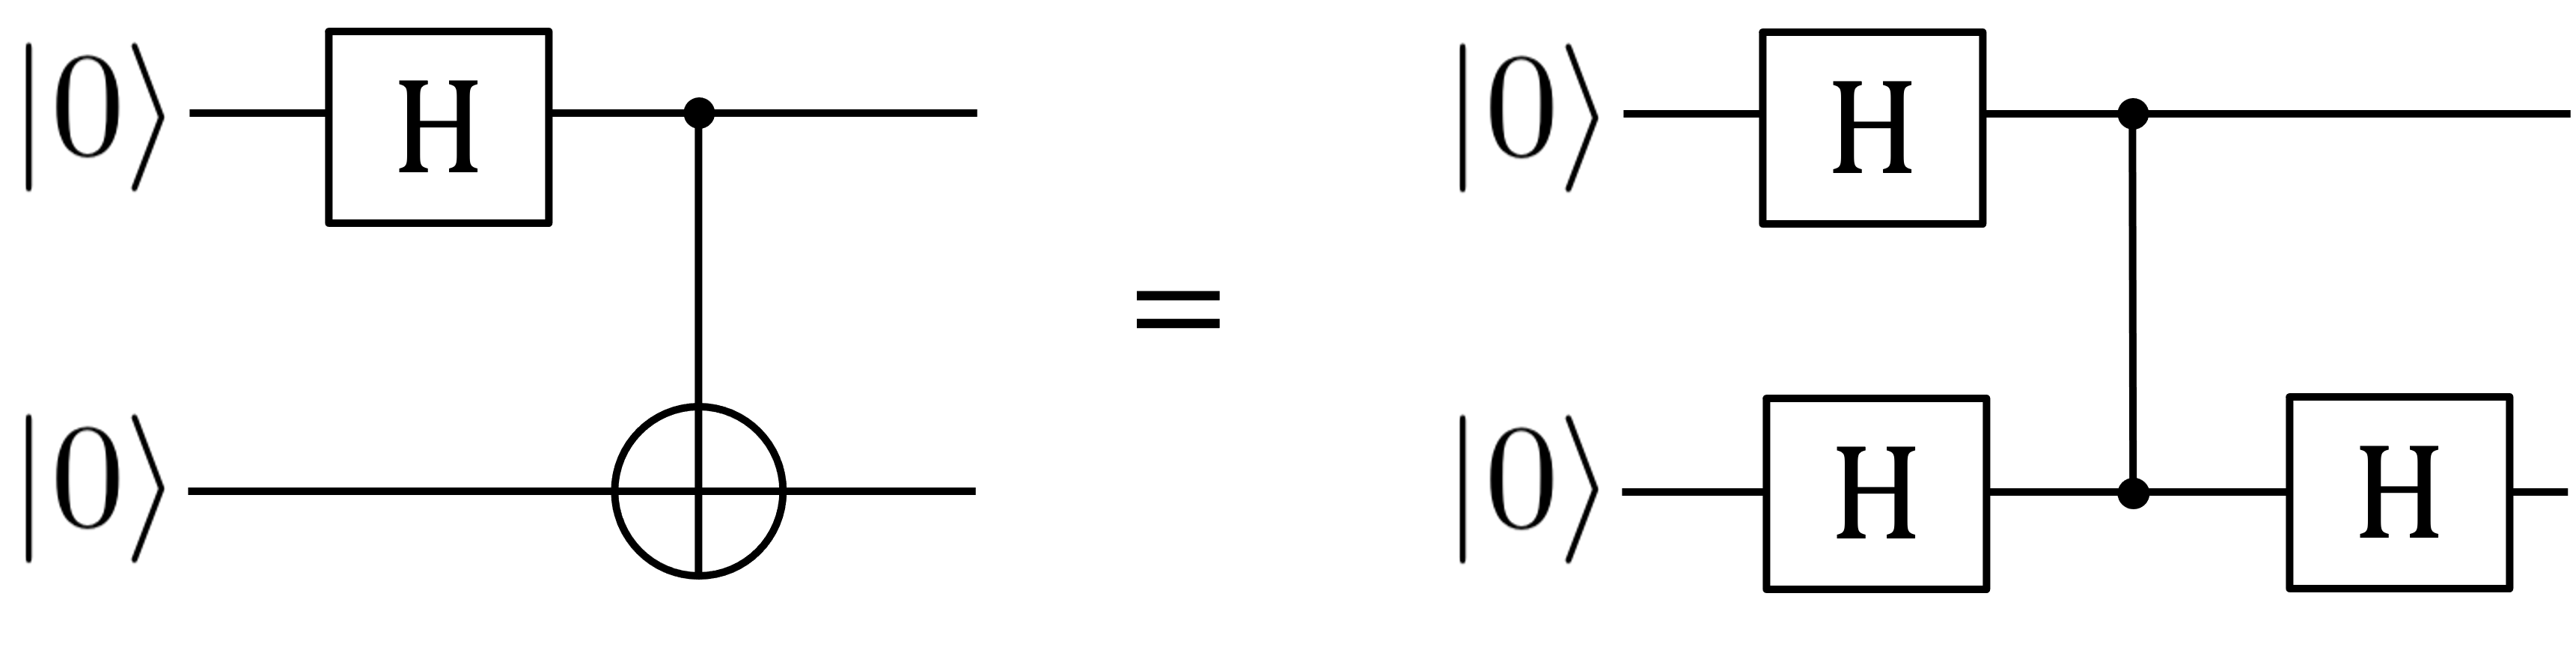
</center>

### Step 2. Transforming the single-qubit gates

<center>
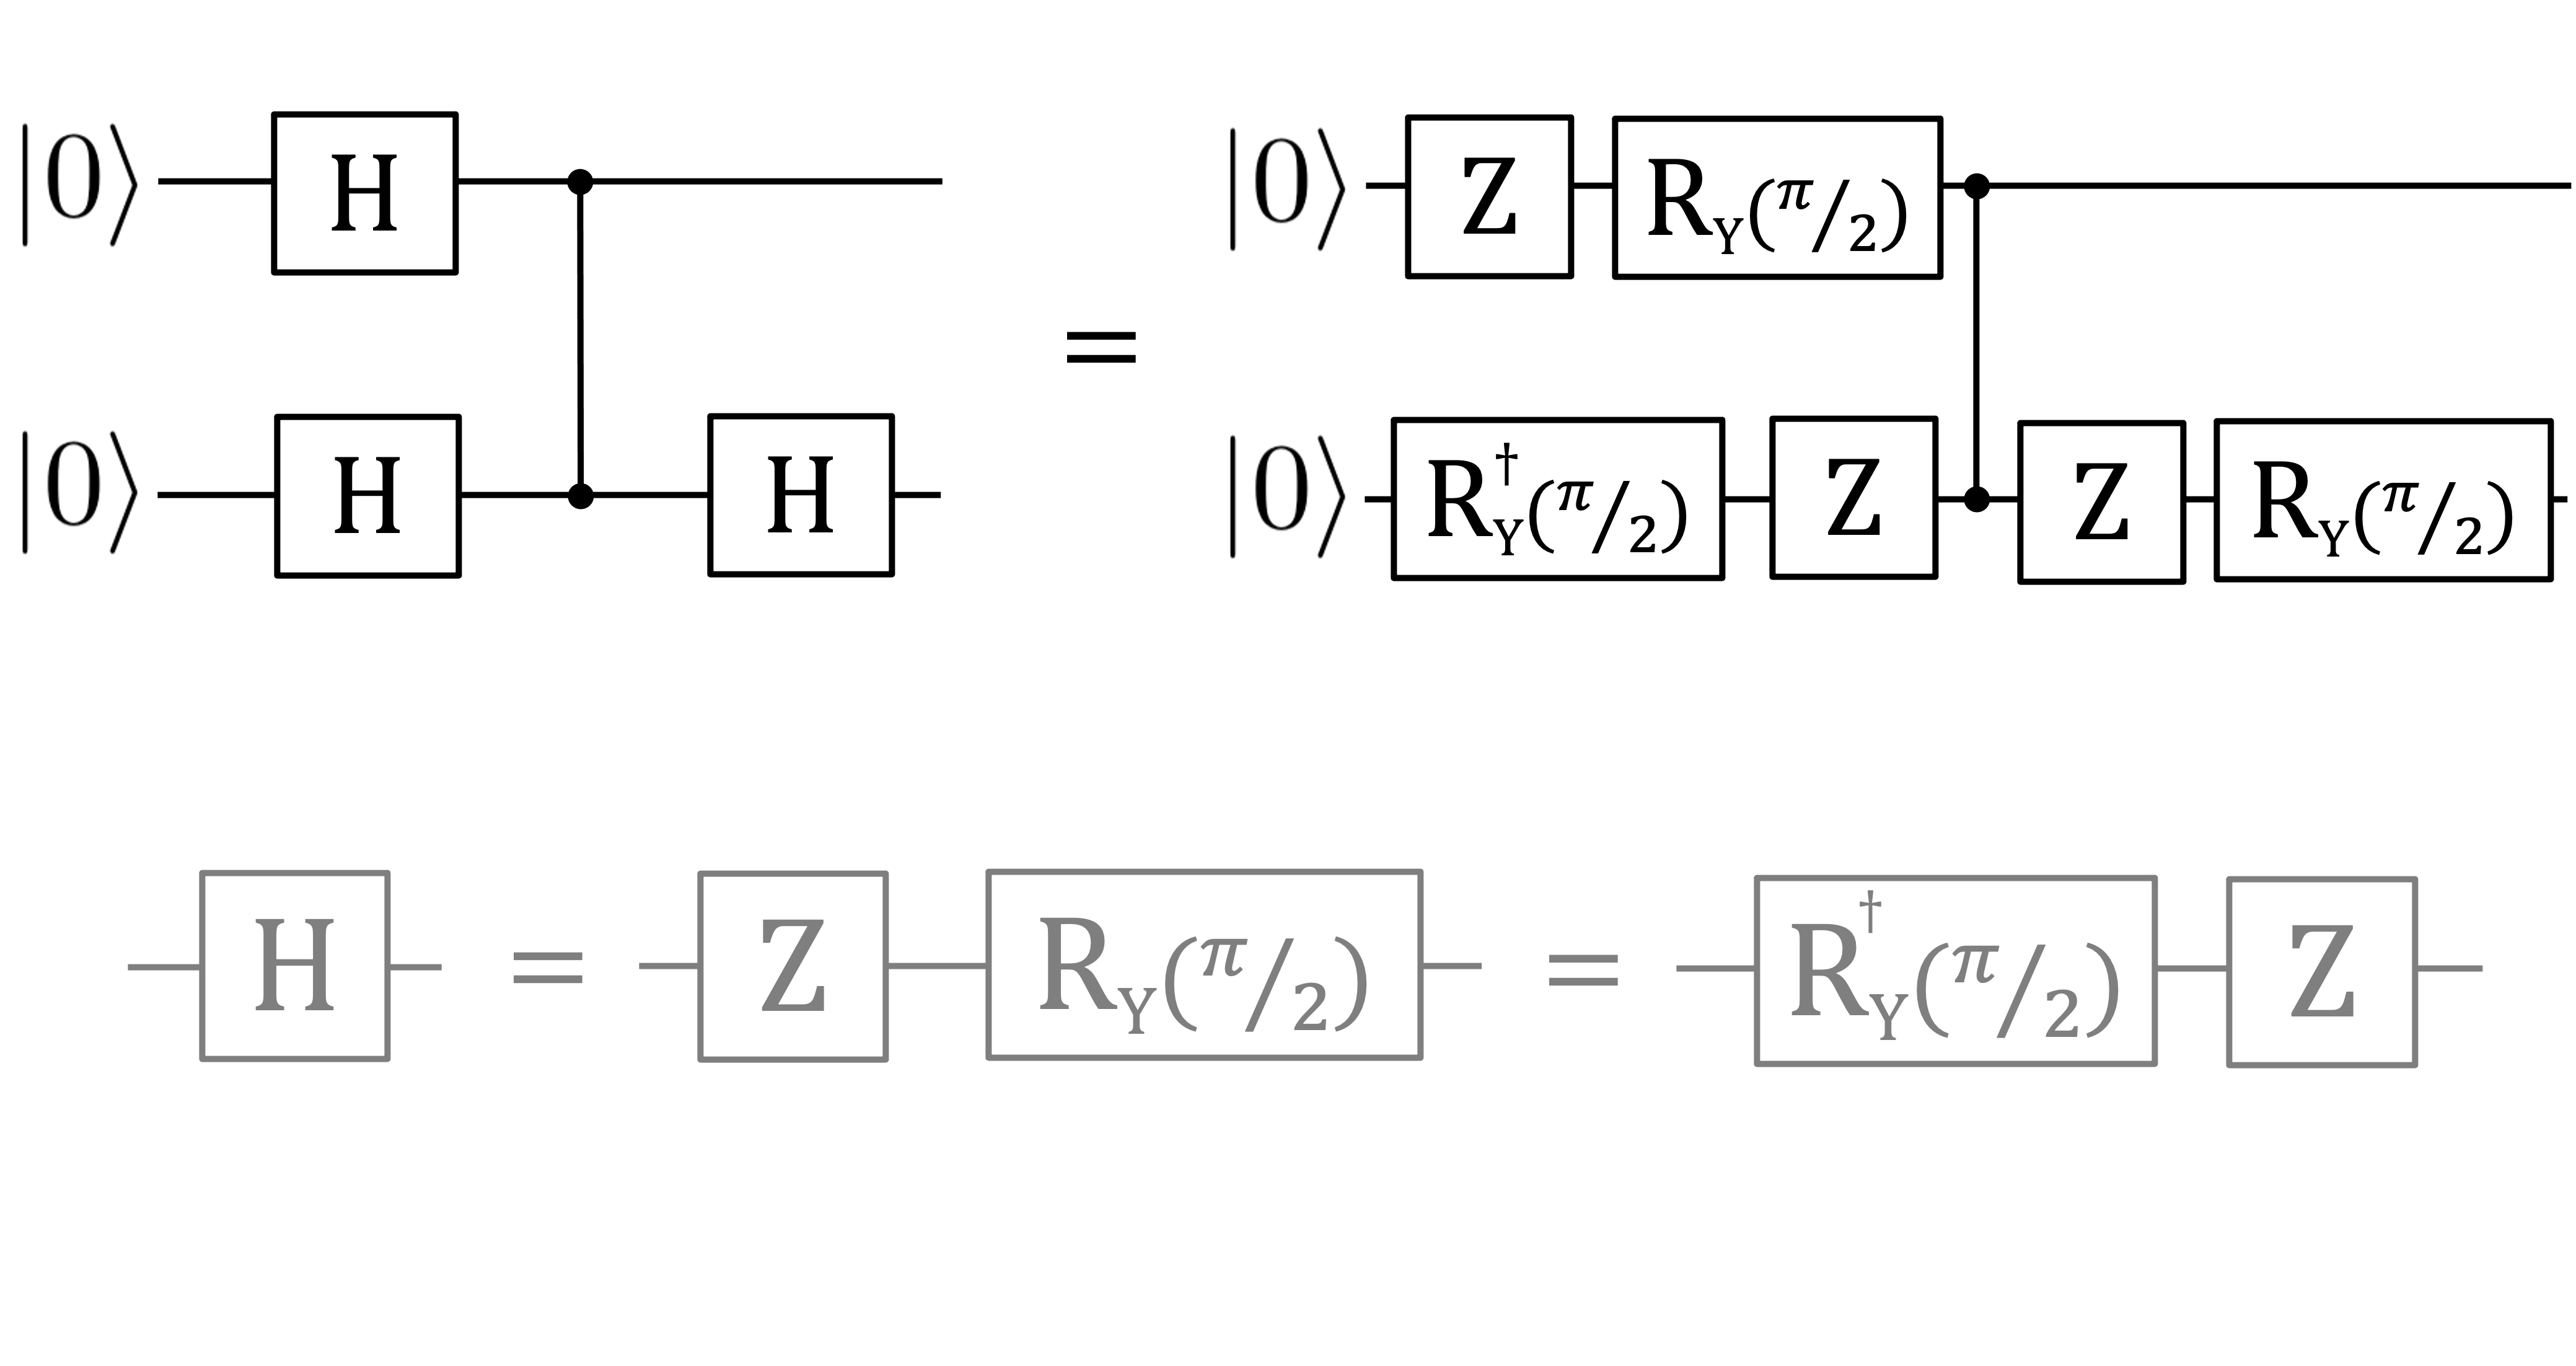
</center>

### Step 3. Eliminating redundant operations

<center>
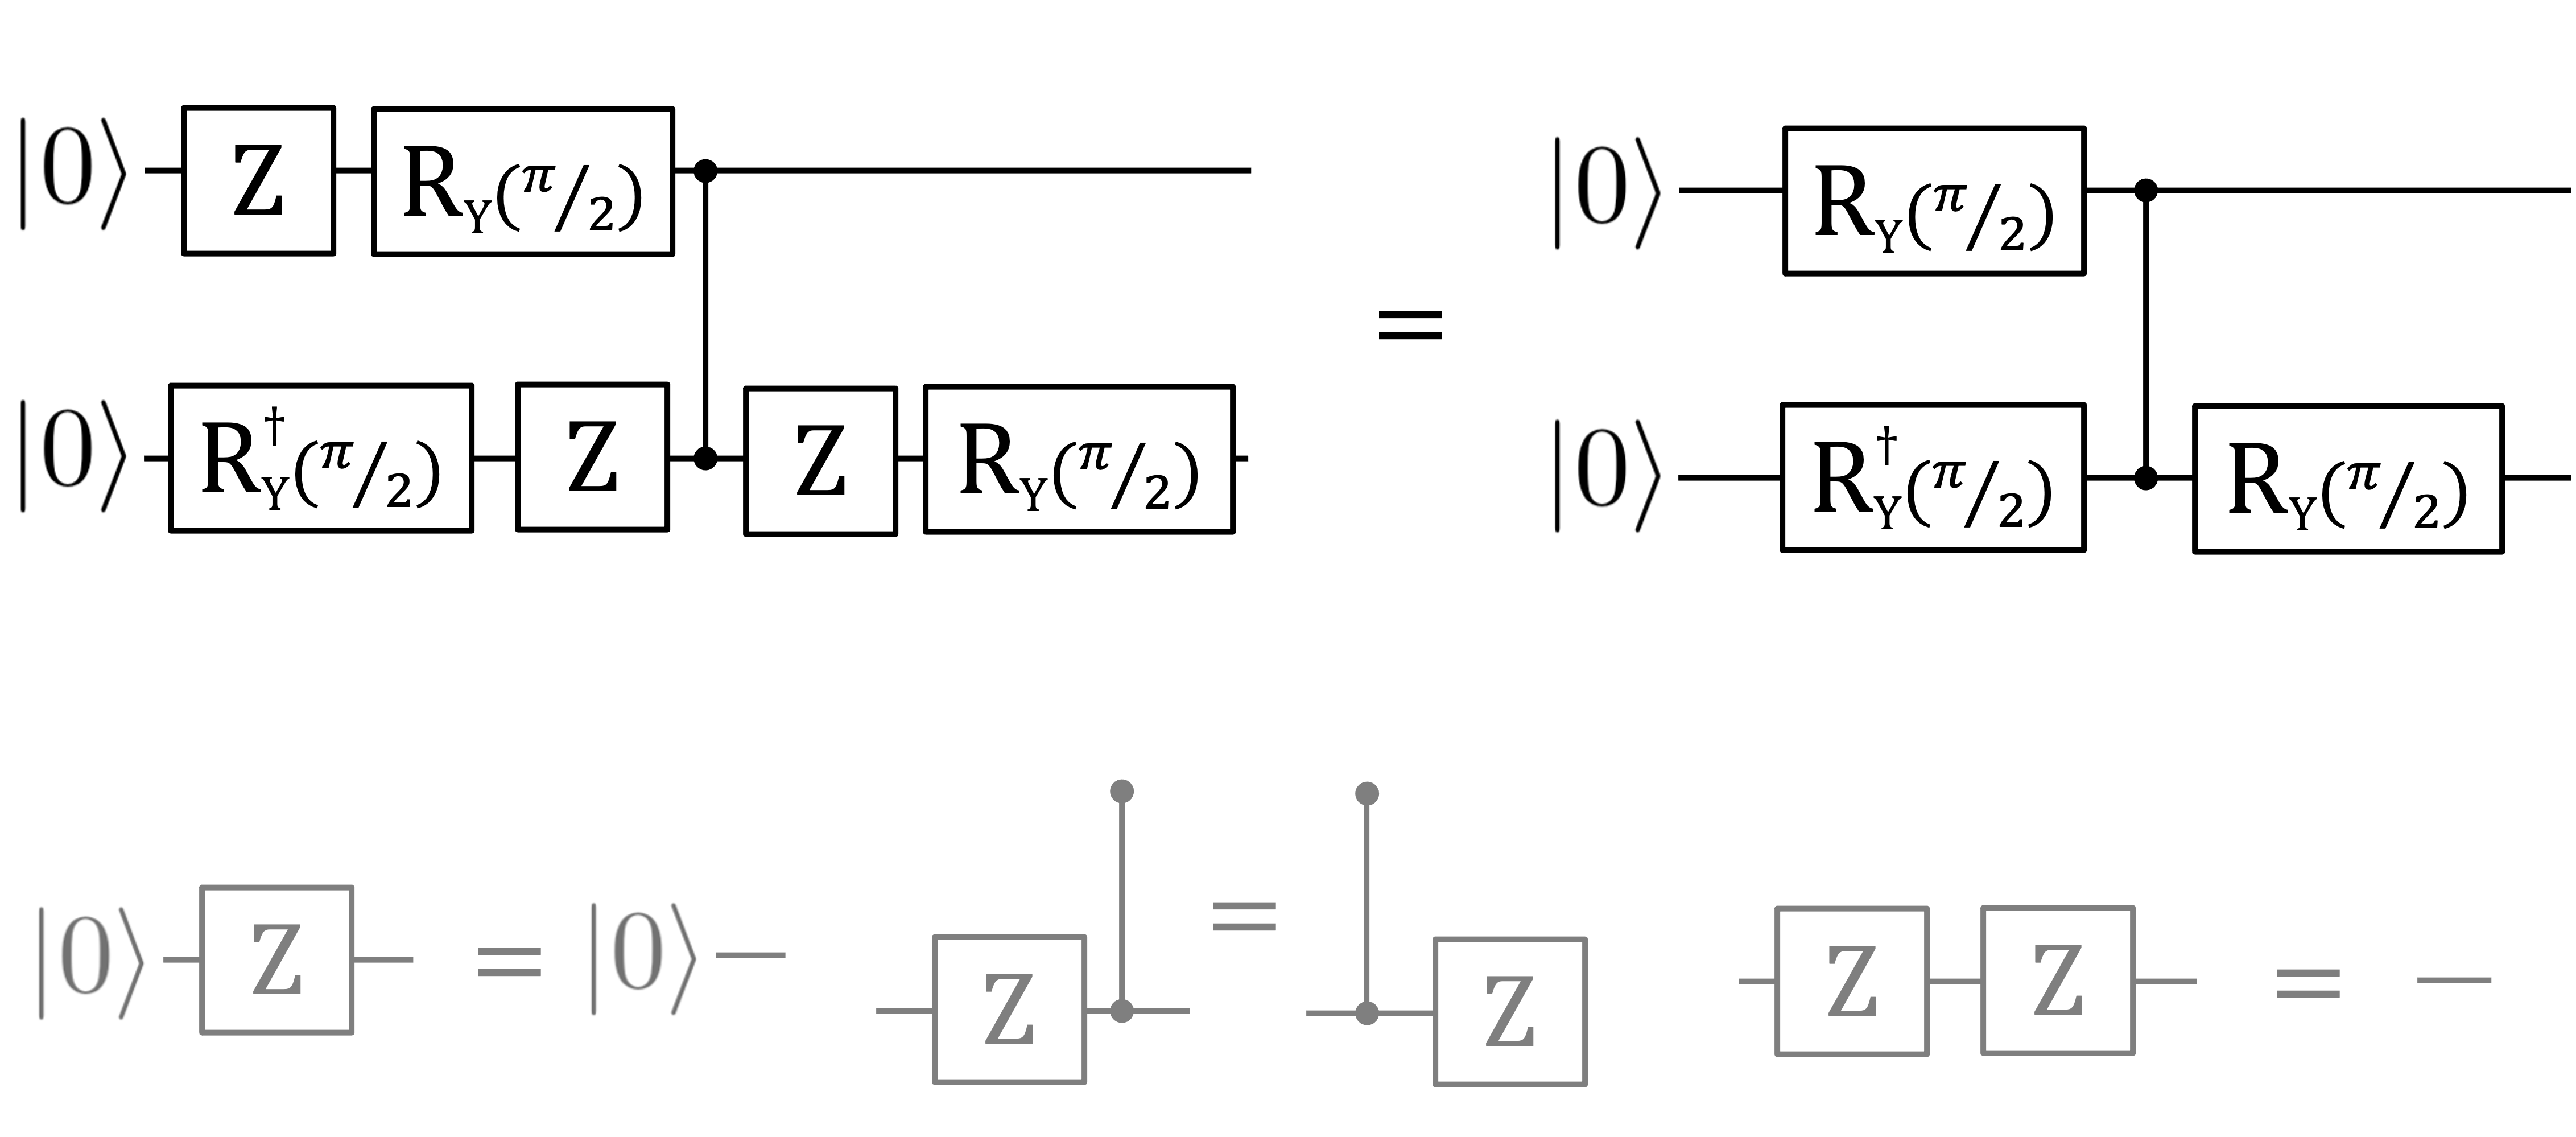
</center>

### Final Quantum Circuit

<center>
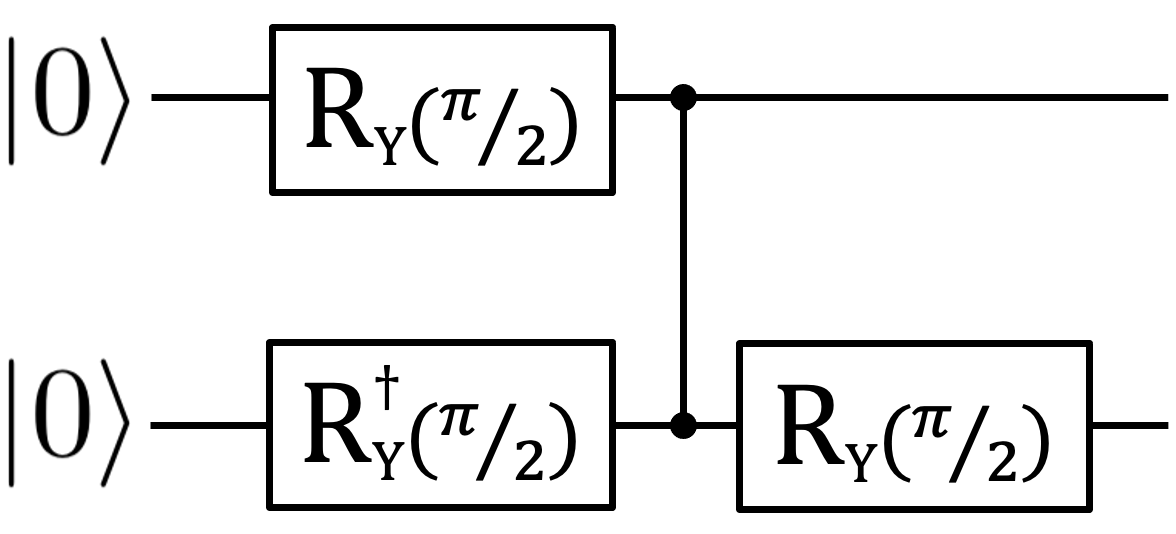
</center>

## 0. Imports

### Third-party libraries

Pulser requires minimal prior knowledge of third-party Python libraries. Usually, the only necessary import is the ubiquituous ``numpy``. More advanced users interested in emulation might benefit from using ``qutip``, but this is not required. Here, we will stick to ``numpy``.

In [ ]:
import numpy as np

### Pulser imports

- The three central classes necessary to make a pulse sequence are ``Sequence``, ``Register``, ``Pulse``
- It is also necessary to choose a device from ``pulser.devices``
- To modulate the pulses, we will need subclasses of the ``Waveform`` class from ``pulser.waveforms``, but we'll import those as we need them.

In [ ]:
from pulser import Sequence, Register, Pulse
from pulser.devices import Chadoq2

## 1. Creating the `Register`

In the `Register` class, we define the name of each atom and its position. We only need two qubits, so we will call them `c` and `t` and position them 4 µm apart.

In [ ]:
qubits = {"c": (-2, 0), "t": (2, 0)}
reg = Register(qubits)
reg.draw()

Though we don't need it here, note that we can also use built-in methods to create our register in a pre-defined pattern. For instance, to make a $4 \text{x} 4$ square array:

In [ ]:
square_reg = Register.square(4, prefix="q")
square_reg.draw()

Other patterns are available, e.g. `Register.triangular_lattice()`, `Register.hexagon()`, ...

## 2. Initializing the `Sequence`

To initialize a `Sequence`, we need a `Register` and a `Device`. The `Register` specifies where the atoms are placed, while the `Device` holds the specifications of the device in which the sequence is to be executed. Here, we use the `Chadoq2` device, which we imported at the top.

In [ ]:
seq = Sequence(reg, Chadoq2)

## 3. Channel declaration

At this point we have an empty `Sequence` in our `seq` variable, so we need to declare the channels we will use. We can consult which channels are available through the command:

In [ ]:
seq.available_channels

We see we have three channels available:

- `rydberg_global`: A `Rydberg` channel with **global** addressing
- `rydberg_local`: A `Rydberg` channel with **local** addressing
- `raman_local`: A `Raman` channel with **local** addressing

Since we are working in the digital setting, we will need the **local** channels, which we will call `rydberg` and `digital`. Also, since the local channels address specific qubits, we can already determine what their initial target will be – here, we set both to target qubit `c`.

In [ ]:
seq.declare_channel("digital", "raman_local", initial_target="c")
seq.declare_channel("rydberg", "rydberg_local", initial_target="c")

## 4. Making the waveforms and pulses

Each `Pulse` is made up of three components: the **amplitude**, the **detuning** and the **phase**. While the phase is a fixed value, the amplitude and the detuning are each represented as a `Waveform`. Here, all our pulses will be resonant (i.e. the detuning will be fixed at 0), so we only care about the amplitude waveform.

Recall that a resonant pulse will describe a rotation of angle

$$\theta = \int^\tau_0 \Omega(t) \text{d}t$$

around the axis of rotation

$$\mathbf{e}(\varphi) = (\cos\varphi, -\sin\varphi, 0)$$

which sits on the equator of the Bloch sphere.

<center>
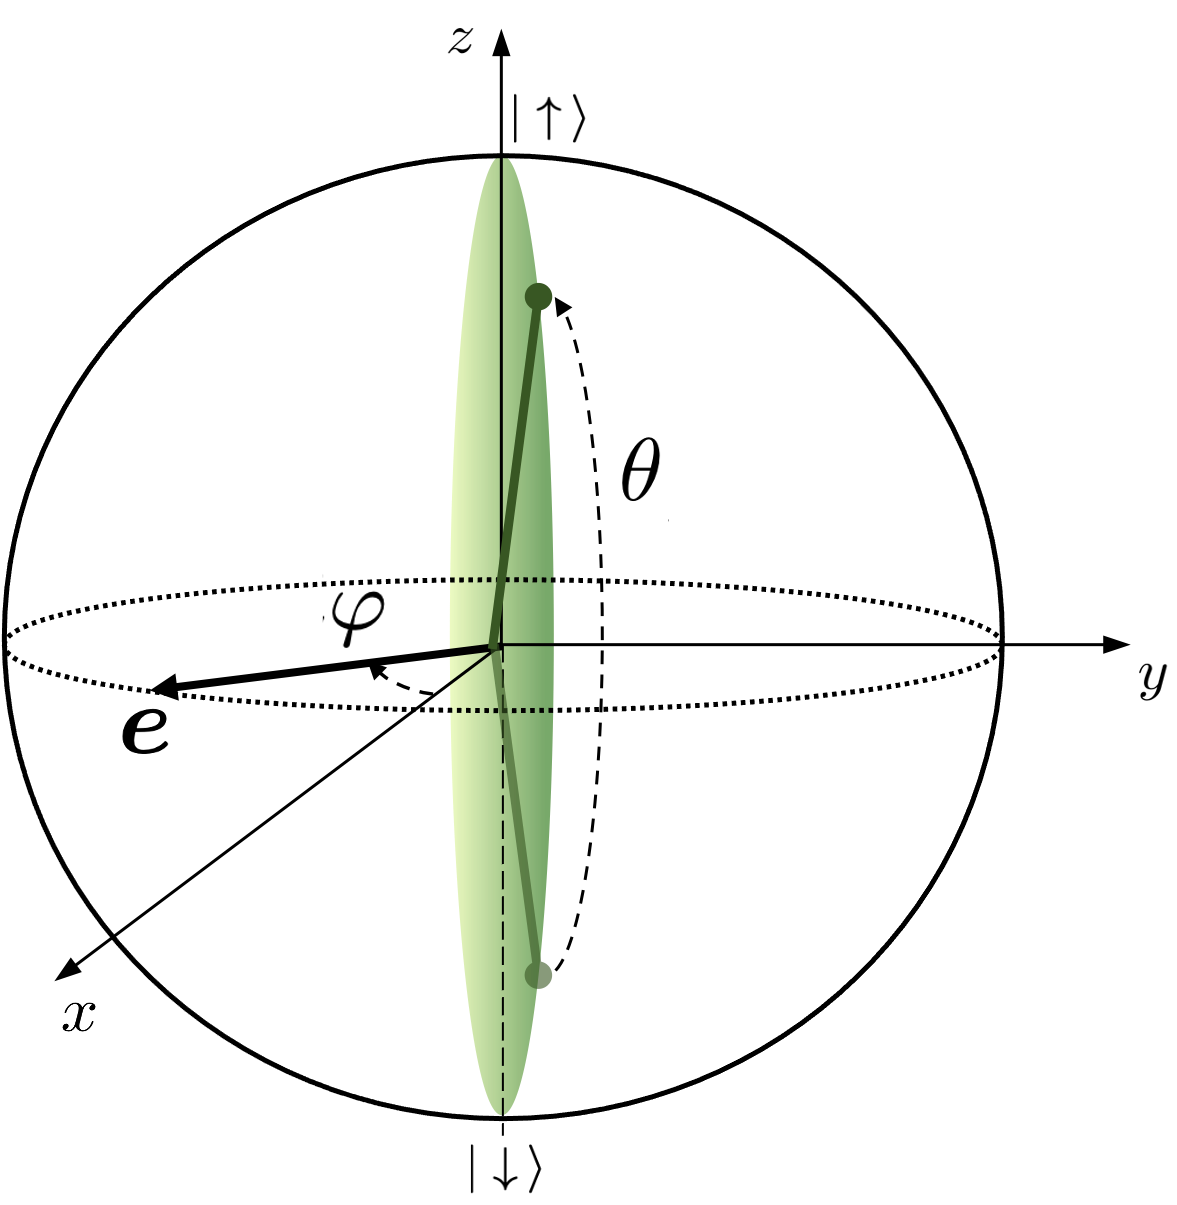
</center>

Then, in theory, we only care about the integral of the Rabi frequency (i.e. the area under the amplitude waveform). In practice, however, our choice of waveform will influence the quality of our gate by mitigating unwanted phenomena like spectral leakage or noise sensitivity. A waveform known to have these qualities is the `BlackmanWaveform`, which we will use first use here to make a waveform with an area of π/2. 

### The single-qubit gates

In [ ]:
from pulser.waveforms import BlackmanWaveform

half_pi_wf = BlackmanWaveform(200, np.pi/2)    # duration: 200 ns, area: π/2
half_pi_wf.draw()

We can now use this waveform to create the pulses which make our single-qubit gates, $R_Y(\pi/2)$ and $R_Y^\dagger(\pi/2)$. Note that $R_Y^\dagger(\pi/2) = R_{-Y}(\pi/2)$, so the axis of rotation is either $Y$ or $-Y$, corresponding to a phase of $-\pi/2$ and $\pi/2$, respectively.

In [ ]:
ry = Pulse.ConstantDetuning(amplitude=half_pi_wf, detuning=0, phase=-np.pi/2)
ry_dag = Pulse.ConstantDetuning(amplitude=half_pi_wf, detuning=0, phase=np.pi/2)

### The CZ gate

Recall that the CZ gate is a three-pulse sequence:

1. π-pulse on the first qubit
2. 2π-pulse on the second qubit
3. π-pulse on the first qubit

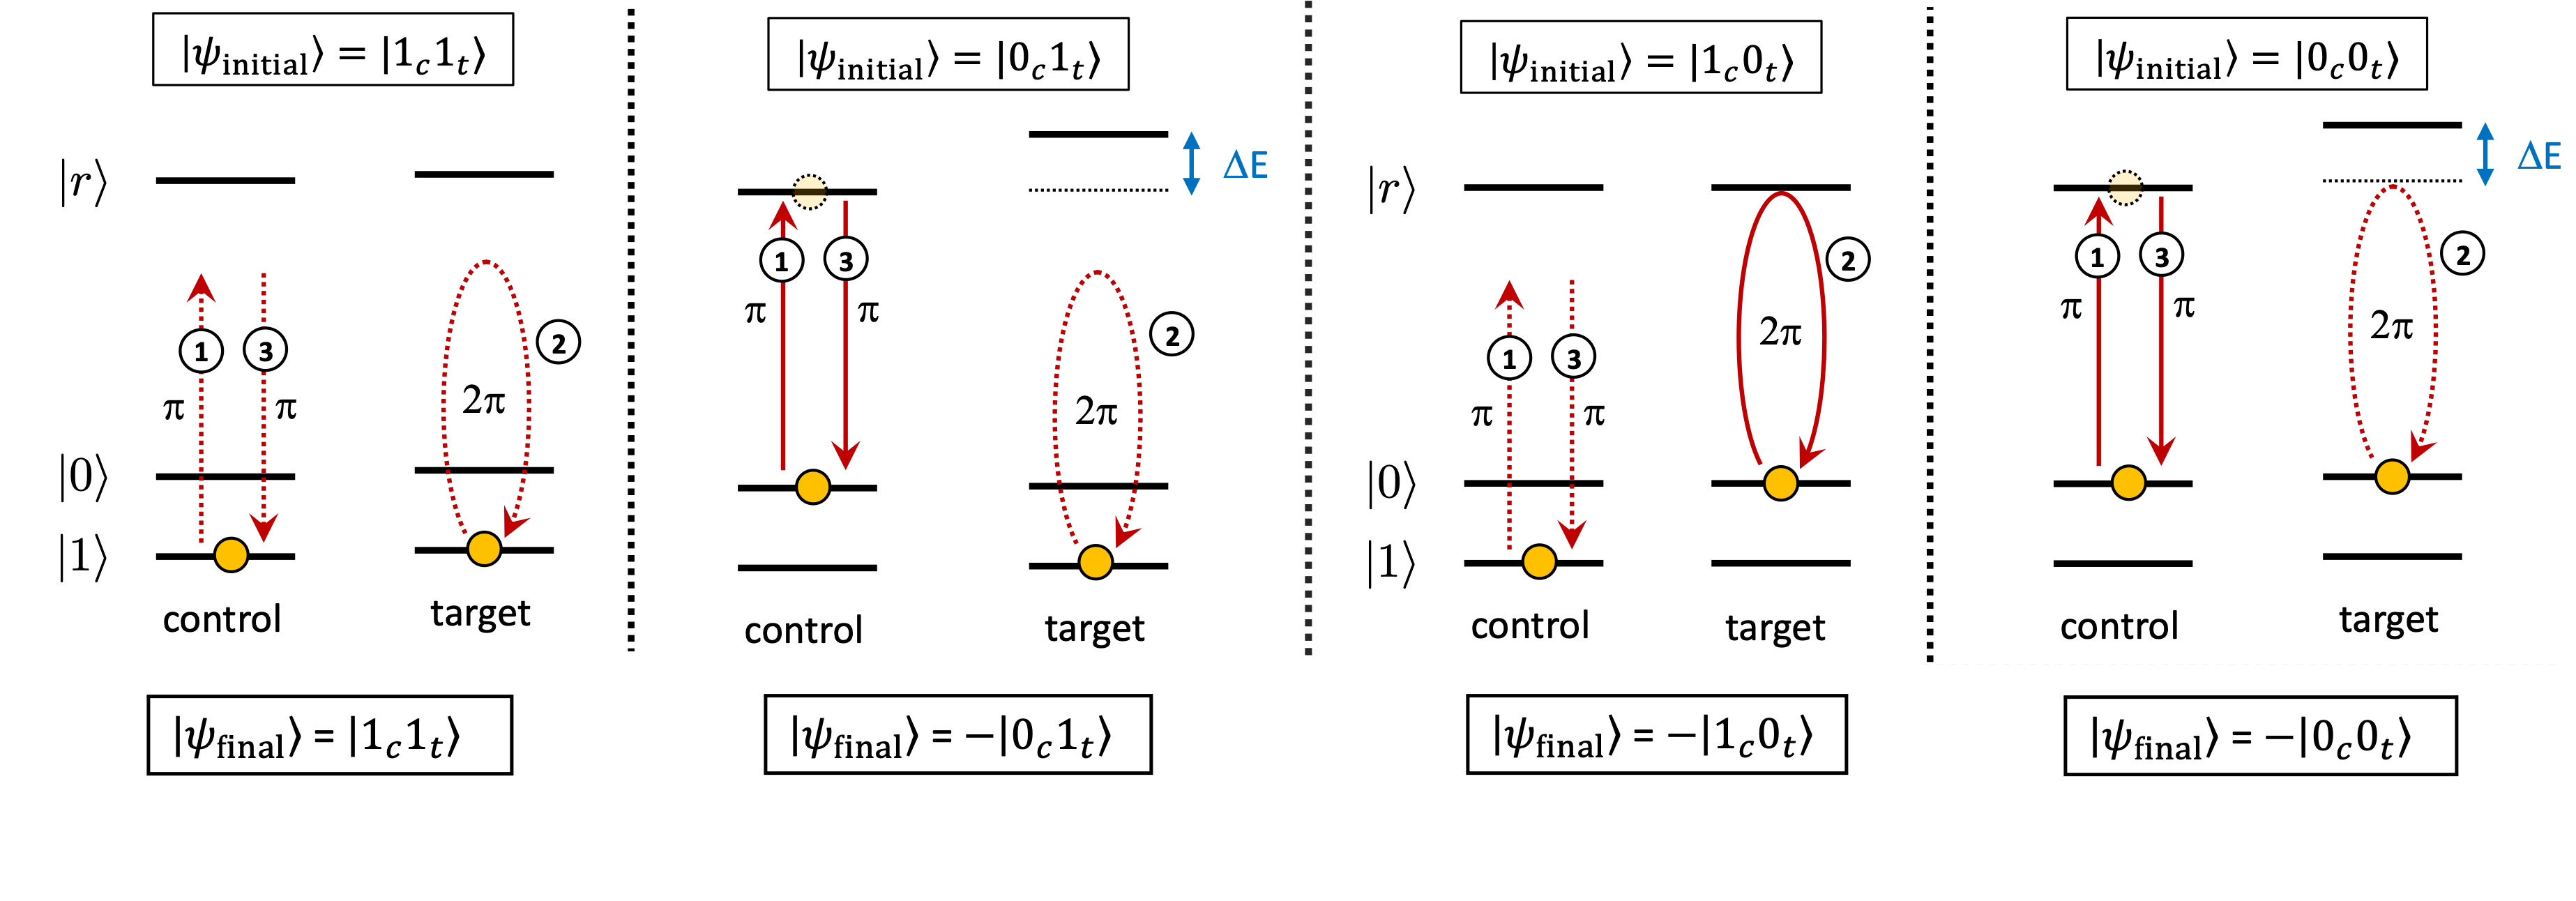
**The CZ gate implementation**: *The first π-pulse attempts to bring the control atom into the Rydberg state, which will condition whether the target will be able to go to $|r\rangle$ and back with the second 2π-pulse, due to the Rydberg blockade. In particular, the $|00\rangle$ state does not experience two consecutive phase flips as it would if the atoms did not interact.*

For the π-pulse, we can repeat what we did for the single-qubit gates: 

In [ ]:
pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

However, more care is needed when it comes to the 2π-pulse. Recall that two Rydberg atoms only interact within a given Rydberg blockade, which is defined as:

$$R_b = \left(\frac{C_6}{\hbar \Omega}\right)^{1/6}$$

This implies that the higher the Rabi frequency is, the smaller the blockade radius will be. Since we want our atoms to be well within a blockade radius of one another, we need to limit our amplitude waveform to ensure this.  Our atoms are 4 µm apart, so let's fix our blockade radius conservatively at 8 µm.

In [ ]:
R_blockade = 8    # µm

We can now use our device to determine the maximum value of Rabi frequency we can hit:

In [ ]:
max_val = Chadoq2.rabi_from_blockade(R_blockade)
max_val

With this, we create the 2π waveform by setting its maximum value and area, which will implictily determine its duration.

In [ ]:
two_pi_wf = BlackmanWaveform.from_max_val(max_val, 2*np.pi)
two_pi_pulse = Pulse.ConstantDetuning(two_pi_wf, 0, 0)
two_pi_pulse.draw()

## 5. Composing the `Sequence`

With all the elements in place, it is finally time to compose the sequence. We start with the first two single-qubit gates:

<center>
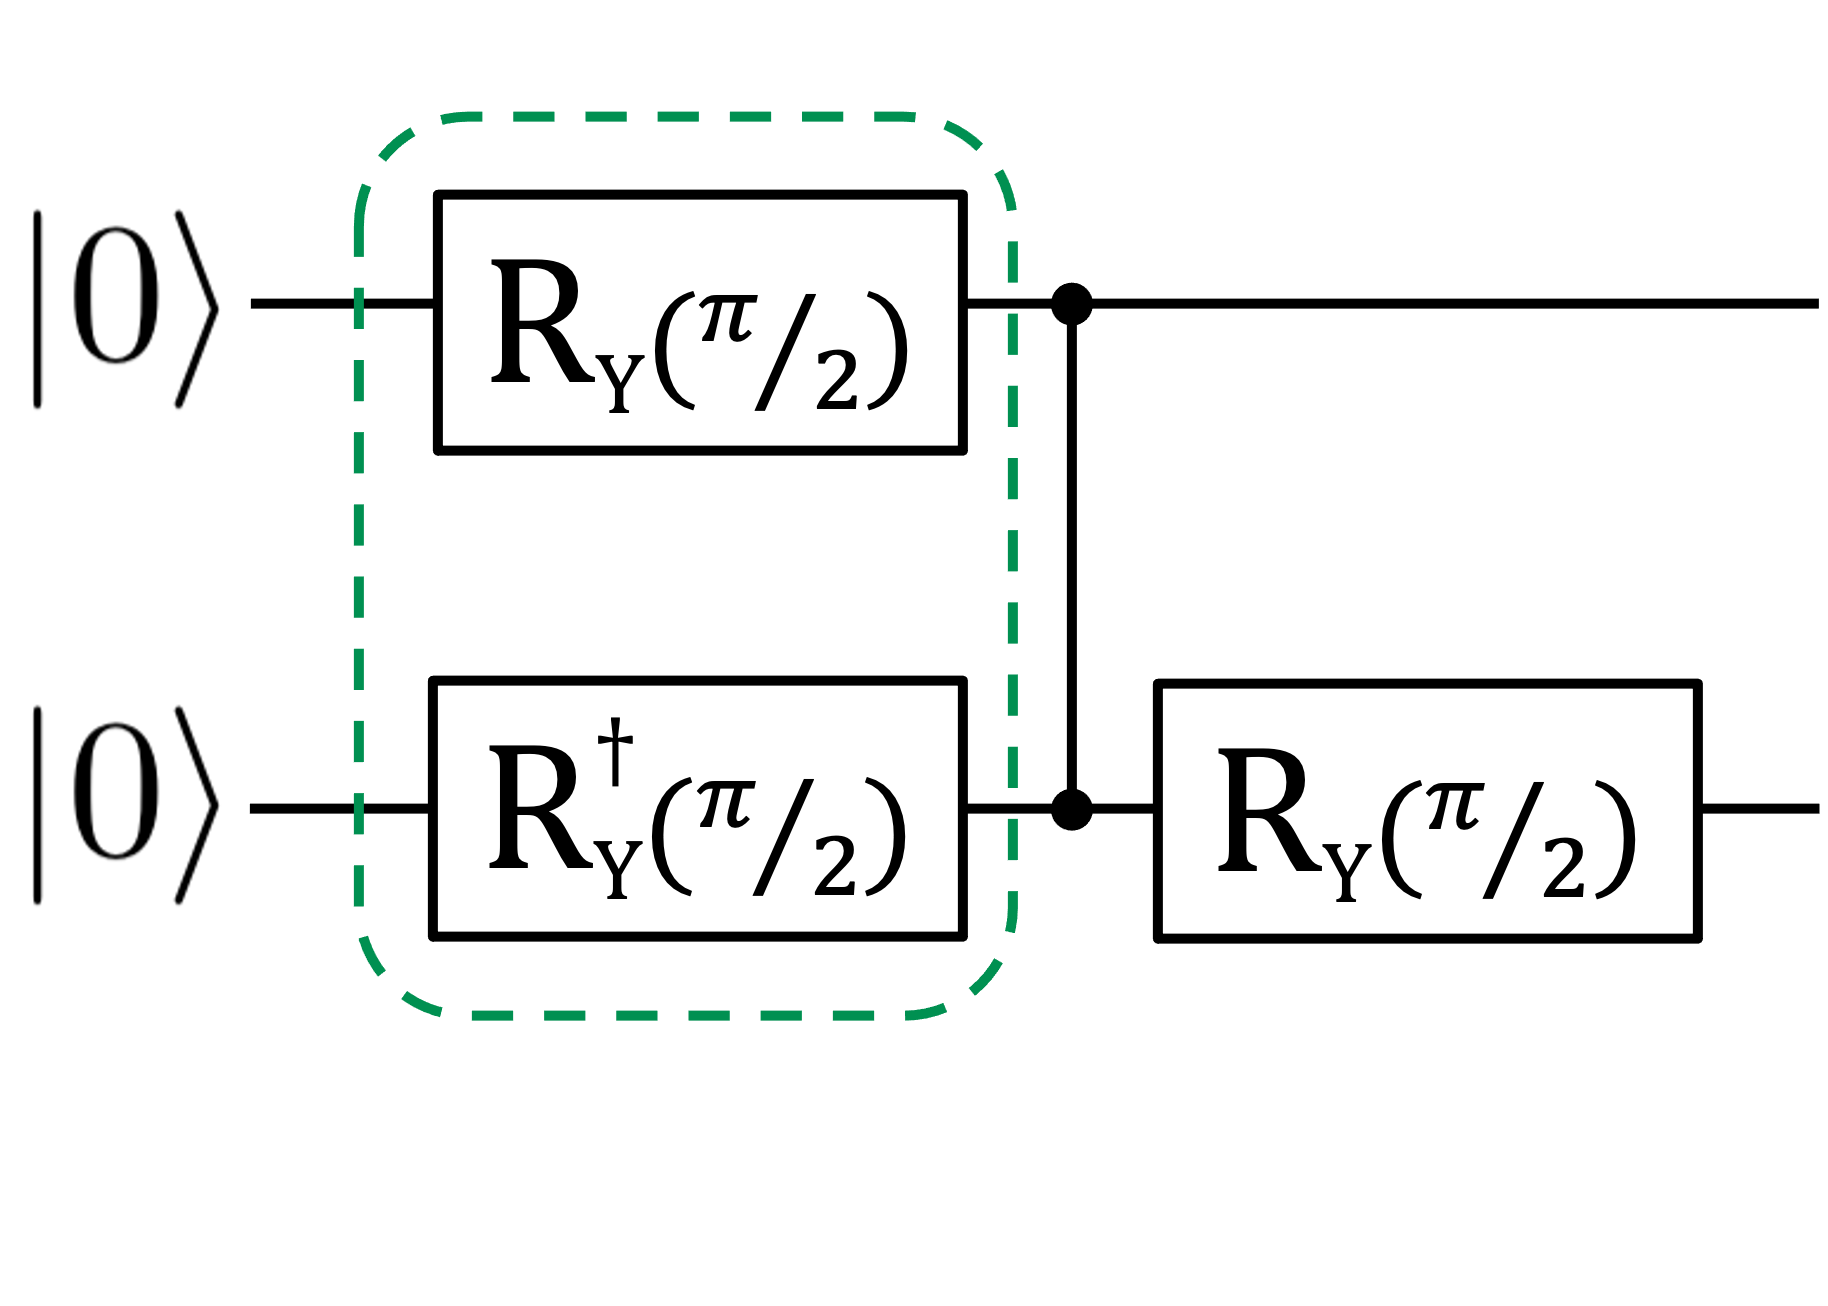
</center>

Note that we only have one channel to do them, so we need to change the target between the two pulses.

In [ ]:
seq.add(ry, "digital")    # Adds the 'ry' pulse to the 'digital' channel
seq.target("t", "digital")    # Changes the target of the 'digital' channel to 't'
seq.add(ry_dag, "digital")    # Adds the 'ry_dag' pulse to the 'digital' channel

We can use the `Sequence.draw()` method to vizualise the sequence as we create it

In [ ]:
seq.draw(draw_phase_area=True)

Moving on to the CZ gate:

<center>
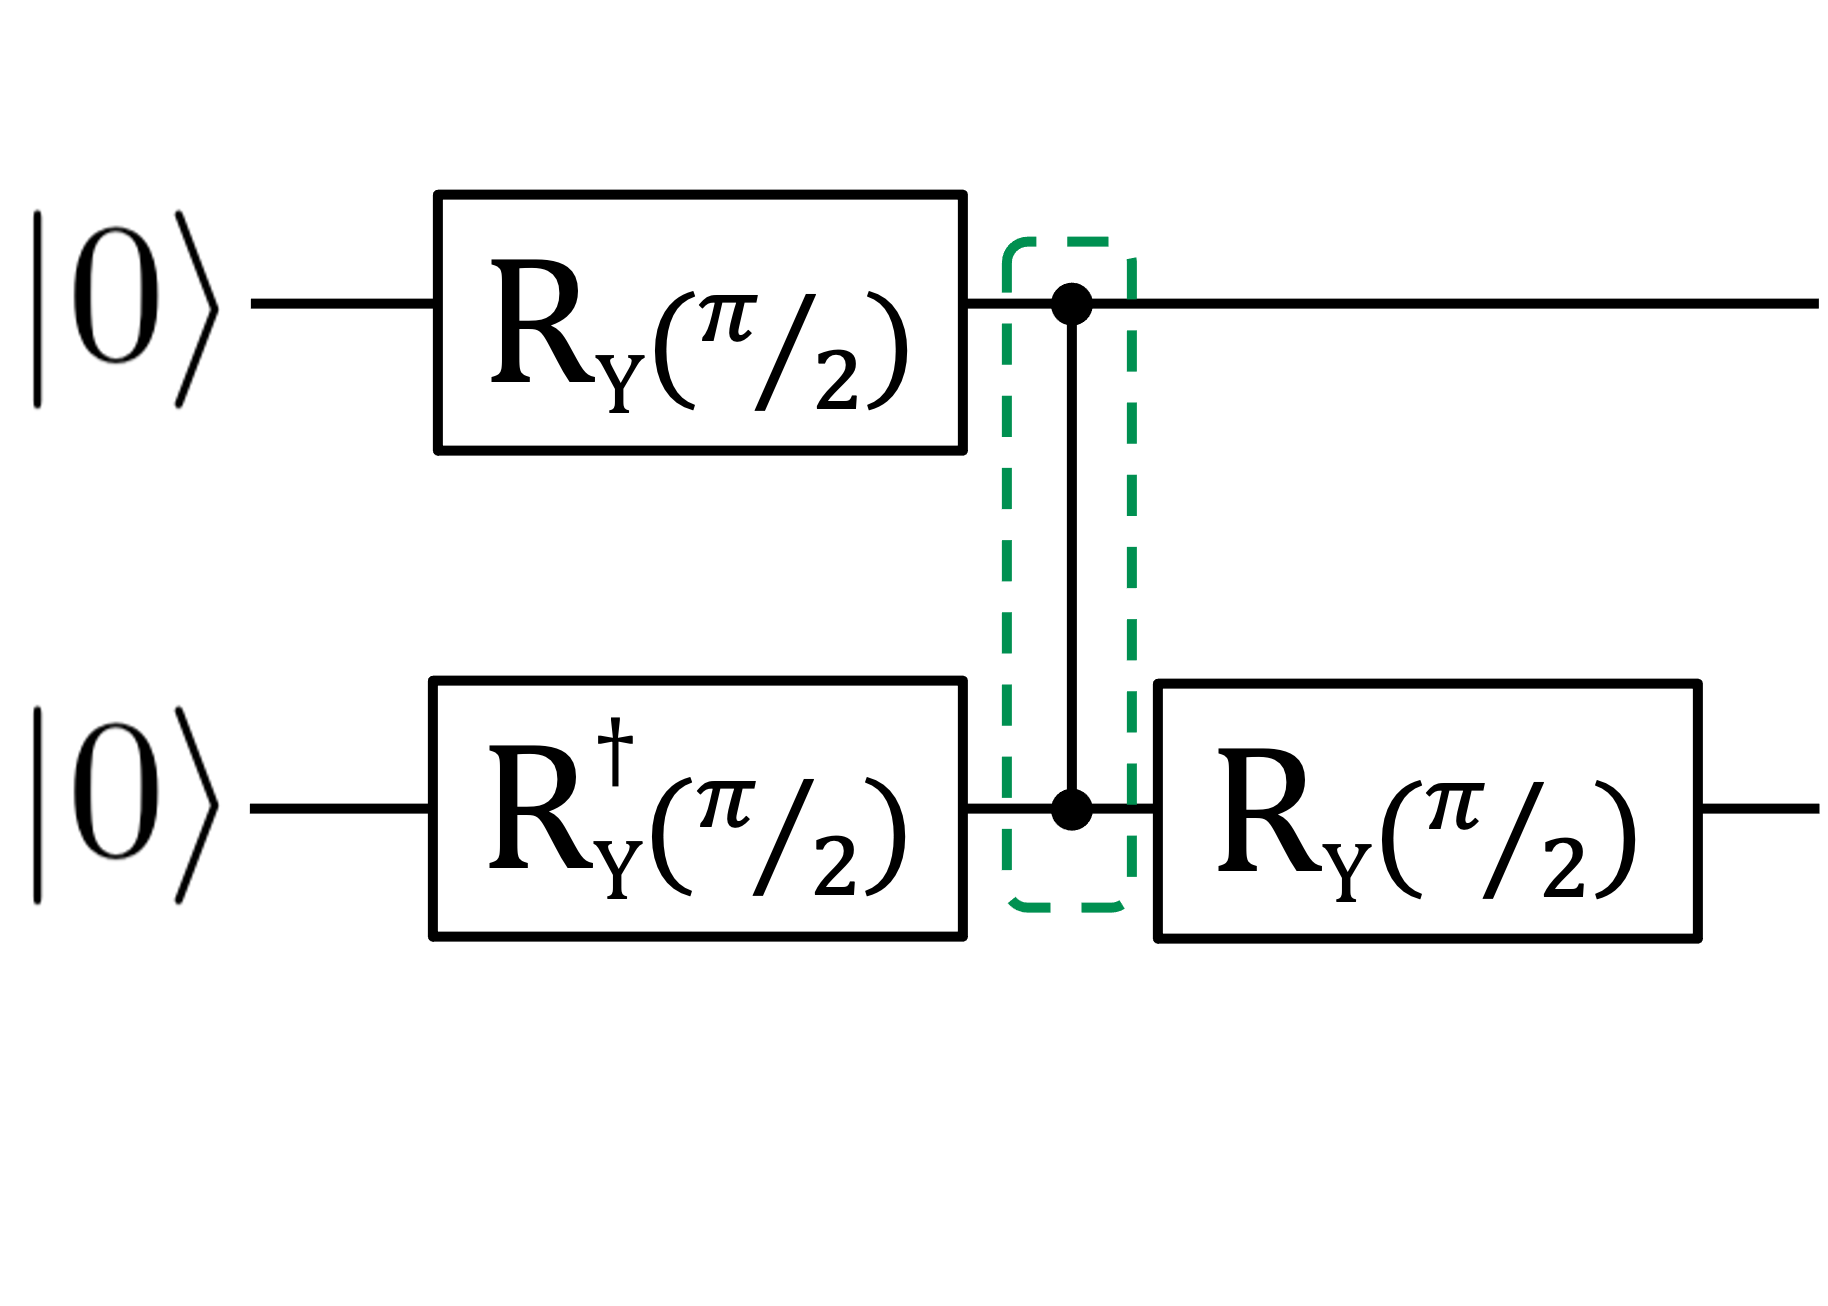
</center>

We start with the `align` command, which tells the `rydberg` channel to start adding pulses once the `digital` channel is over.

In [ ]:
seq.align("digital", "rydberg")

seq.add(pi_pulse, "rydberg")    # 1st π-pulse on 'c'
seq.target("t", "rydberg")    # Changes target to 't'
seq.add(two_pi_pulse, "rydberg")    # 2π-pulse on 't'
seq.target("c", "rydberg")    # Changes target back to 'c'
seq.add(pi_pulse, "rydberg")    # 2nd π-pulse on 'c'

seq.draw(draw_phase_area=True)

Finally, we take care of the last single-qubit gate:

<center>
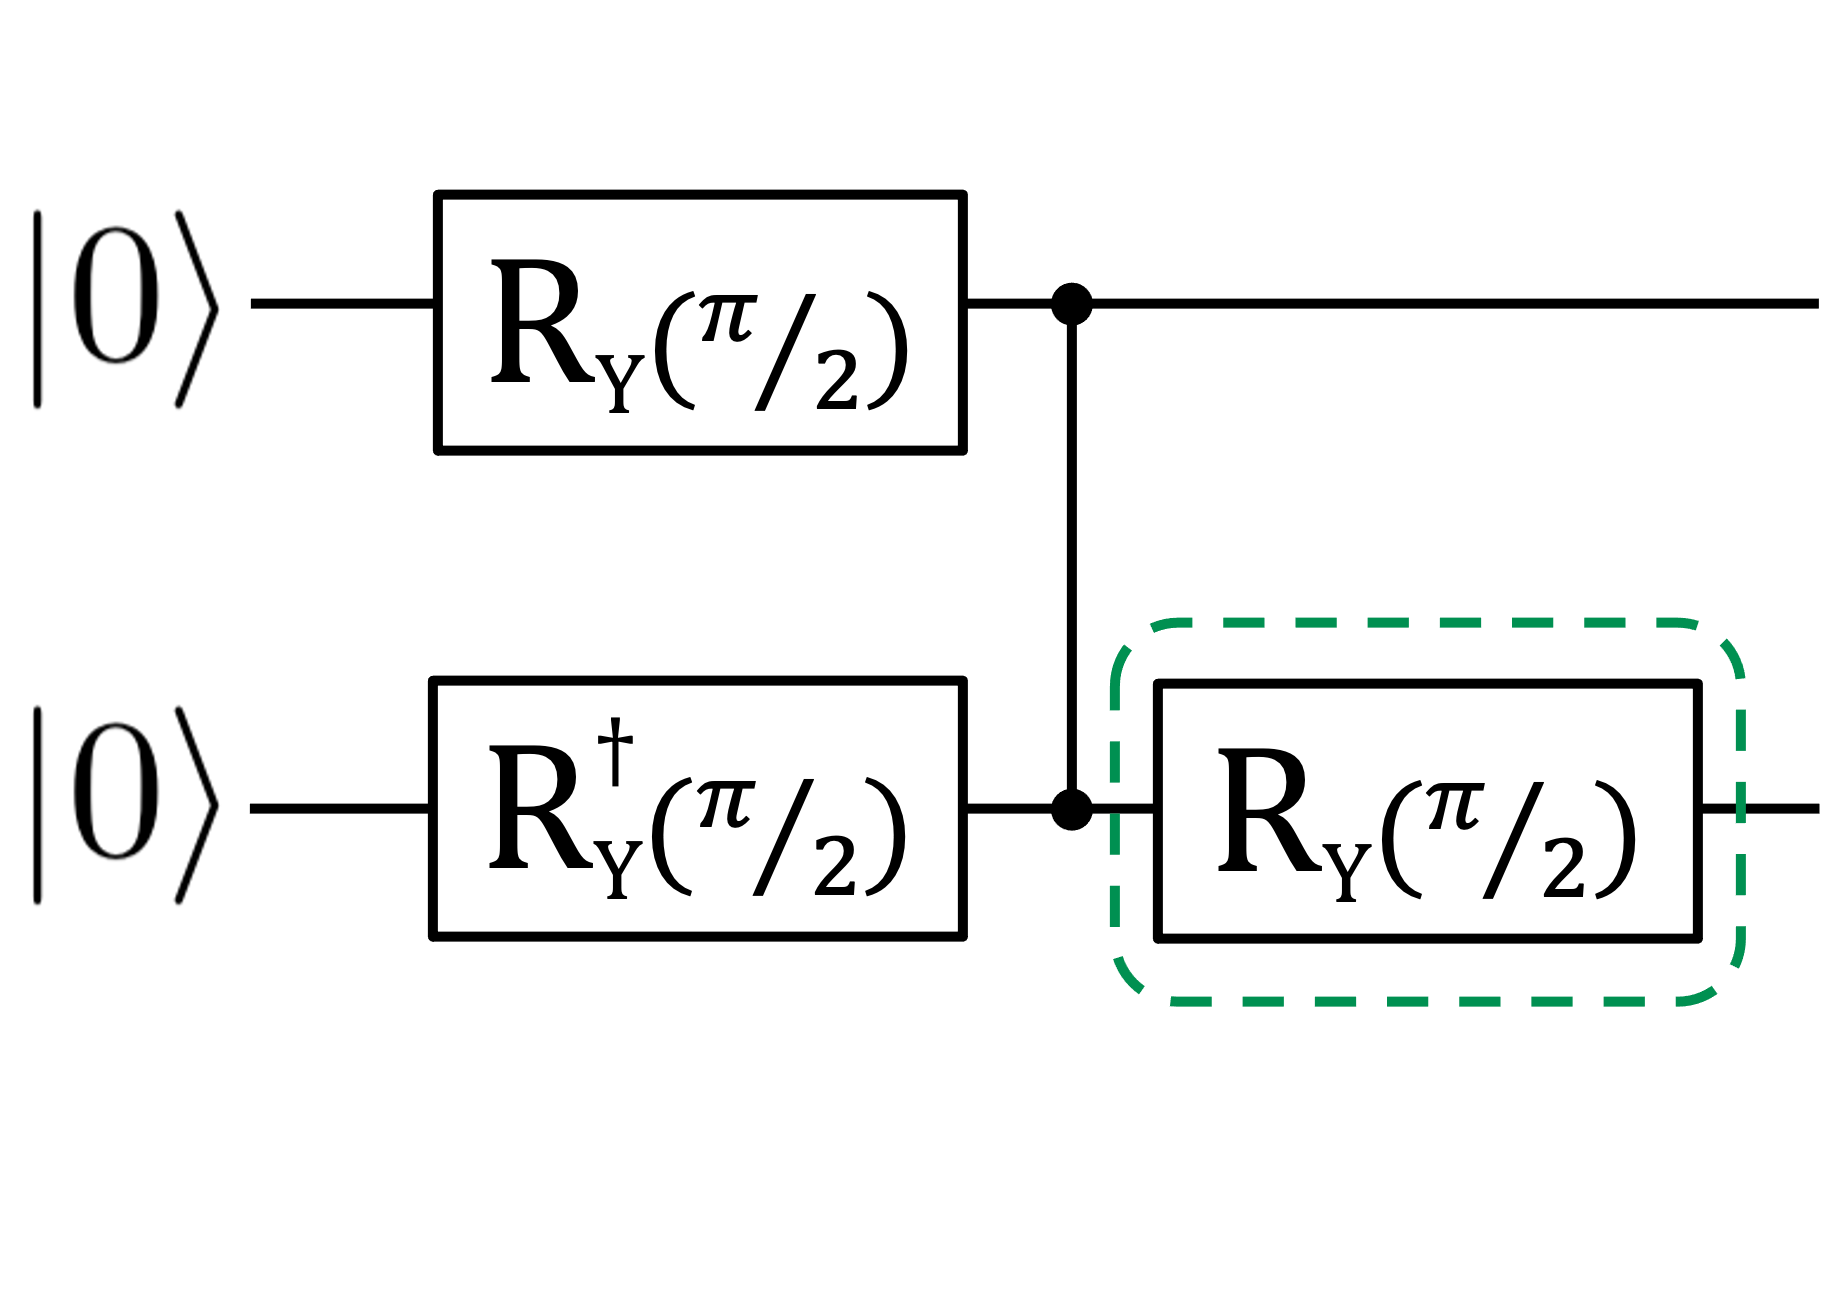
</center>


In [ ]:
seq.align("digital", "rydberg")
seq.add(ry, "digital")

We finish with the measurement, which we specify is in the `digital` basis:

In [ ]:
seq.measure("digital")

Thus, we have our full sequence:

In [ ]:
seq.draw(draw_phase_area=True)

Alternatively, we can also print it out:

In [ ]:
print(seq)

## 6. Results simulation

In Pulser, we can also emulate the execution of a pulse sequence with the `simulation` module. The central element is the `Simulation` class, which we'll import:

In [ ]:
from pulser.simulation import Simulation

There are multiple features and configurations in the `simulation` module, but for now, we'll stick to initalizing a `Simulation` instance and running it with the default settings. 

In [ ]:
sim = Simulation(seq)
results = sim.run(progress_bar=True)

`results` holds the state vectors describing the whole system through the entire sequence. For instance, we can access the final state:

In [ ]:
results.get_final_state()

We can see that our state vector has size 9, since we modeled the state of each atom in a three-level system (the two hyperfine ground states enconding the qubit state, $|h\rangle$ and $|g\rangle$, plus the auxiliary Rydberg state, $|r\rangle$). 

However, the population of the Rydberg states should be negligible, since we always bring the atoms back to the ground state. In these cases, it is possible to reduce the state vector to the meaningful basis (in this case, the `digital` basis):

In [ ]:
results.get_final_state(reduce_to_basis="digital")

And indeed, we obtain the intended state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} $.

To emulate the results we would get out of a QPU, we can instead sample the final state a given number of times and obtain the distribution over the measured outcomes:

In [ ]:
results.sample_final_state(N_samples=1e4)

Yet again, we observe that we measure one of the two intended states with ~50% probability.